## Baseline thesis experiment MVP
 
This notebook provides the proof of concept for the baseline experiment for the thesis. That is, this implements the **multi-task learning** experiment from Lazaridou, Potapenko and Tieleman (2020), using the MS COCO dataset. The goal of the notebook is to ensure the conceptal and technical correctness of the code; the efficiency and minor updates to the flow of the process are still subject to improvement. 

I would really appreciate feedback on code contained in cells indicated with **<-- please check me -->**; these are also the ones containing code which I have questions about. 

In [1]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import json
from random import shuffle
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torchtext.data import get_tokenizer
import numpy as np
import math
import time
import sys
import re
import pandas as pd

In [2]:
# set seed
torch.manual_seed(42)

### Utilities

First, some utility functions are implemented. The Vocabulary class instantiates or loads the vocabulary (full vocabulary constructed from the entire dataset for now). The Dataset class loads image-caption pairs. The `get_loader` provides a DataLoader for training. 

In [26]:
# utils: vocab used by the agents (shared)

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="START",
        end_word="END",
        unk_word="UNK",         
        annotations_file="captions_val2014.json",
        pad_word="PAD",
        vocab_from_file=False):
        """
        Initialize the vocabulary.
        Args:
        -----
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          pad_word: Pad token.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        # create / load the vocab
        self.get_vocab()

    def get_vocab(self):
        """
        Load the vocabulary from file OR build the vocabulary from scratch.
        """
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """
        Populate the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.init_vocab()
        # add special tokens andd all tokens from all captions
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_word(self.pad_word)
        self.add_captions()

    def init_vocab(self):
        """
        Initialize the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.word2idx = {} 
        self.idx2word = {} 
        self.idx = 0

    def add_word(self, word):
        """
        Add a token to the vocabulary.
        Args:
        ----
            word: str
                Token to be added.
        """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """
        Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold.
        """
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            caption = caption.lower().strip()
            caption = re.sub(r"[^a-zA-Z.,!?]+", r" ", caption)
            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(caption) 
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        """
        Return index of given word.
        Args:
        ----
            word: str
        Returns:
            int: index of word
        """
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        """
        Returns number of unique tokens in vocabulary. 
        """
        return len(self.word2idx)

In [9]:
# build a dataset generator
# padding will be made more consistent across pre-training and reference game training

class COCOCaptionsDataset(Dataset):
    """
    Custom class for preprocessing datapoints and sampling a random caption per image.
    For training, 70.000 images are sampled.
    
    Args:
    ----
        file: str
            Path to annotations json file.
        download_dir: str
            Path to root directory containing images and annotations.
        img_transform: transformations.Compose
            Transformations to be applied to the loaded image before it is embedded.
        batch_size: int
            Batch size.
        mode: str
            Train, test or validation.
        vocab_threshold: int
            Minimal token frequency to be considered in the vocab.
        vocb_file: str
            Path to vocab file.
        start_toke, end_token, unk_token, pad_token: str
            Special tokens.
        vocab_from_file: bool
            Load existing vocab from file?
        max_sequence_length: int
            Max length to which captions will be truncated.
        
    """
    def __init__(self, file, download_dir, img_transform, batch_size, mode, 
                 vocab_threshold, vocab_file, start_token, end_token, unk_token, pad_token, 
                vocab_from_file, max_sequence_length=0):
        """
        Initialize a dataset instance loading image-caption pairs from the MS COCO Captions dataset.
        """
        self.transform = img_transform
        self.mode = mode
        self.batch_size = batch_size
        # instantiating the vocab object 
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, file, pad_token, vocab_from_file) 
        self.max_sequence_length = max_sequence_length
        self.pad_token = pad_token
        
        # some distinctions below for Train and test mode (root dir and whether there are captions)
        if mode == "train":
            self.image_dir = os.path.join(download_dir, "train2014")
            self.coco = COCO(file) 
            _ids = list(self.coco.anns.keys())
            shuffle(_ids)
            # take 70.000 images from the dataset
            self.ids = _ids[:70000]
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") 
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))]
            self.caption_lengths = [len(token) for token in all_tokens]
            # get maximum caption length for padding
            self.max_caption_length = max(self.caption_lengths)
            
            # print pretraining IDs for later separation from functional training
            with open("pretrain_img_IDs.txt", 'w') as f:
                f.write(",".join([str(i) for i in self.ids]))
                
        elif mode == "val":
            self.image_dir = os.path.join(download_dir, "val2014")
            self.coco = COCO(file) 
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english")
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))] # tqdm(np.arange(len(self.ids)))
            self.caption_lengths = [len(token) for token in all_tokens]
            
        else:
            self.image_dir = os.path.join(download_dir, "val2014")
            # no annotations here 
            test_info = json.loads(open(file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
    
    def __len__(self):
        """
        Return number of available data points.
        """
        if self.mode != "test":
            return len(self.ids)
        else:
            return len(self.paths)
    
    def __getitem__(self, idx):
        """
        Return an image-caption tuple. A random caption per images is chosen since the dataset maps captions onto images.
        
        Arguments:
        -------
        idx: int
            Index of the item to be returned.
        Returns:
        -----
        image: torch.tensor((3,224,224))
        caption: torch.tensor((len_caption))
        """
        
        # obtain image and caption if in training mode
        if self.mode != 'test':
            ann_id = self.ids[idx]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            image = self.transform(image)

            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(str(caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            
            # check if the sequence needs to be truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]
                
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()
            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[idx]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image
        
    def get_train_indices(self):
        """
        Return a list of indices at which the captions have the same length which was sampled at random 
        for the given batch. To be used for pretraining the speaker (base image-captioning model).
        
        Returns:
        -----
            indices: list
                List of indices of caption-image pairs to be used in the batch.
        """
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        
        return indices
    
    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices for the functional training. 
        Returns a list of inidces for targets and a list f indices for distractors. 
        Captions are of same lengths for targets and distractors (will be optimized).
        
        Returns:
        -------
            list: (int, int)
                List of tuples of target and distractor indices, each for a single reference game iteration.
        """
        
        sel_length_t = np.random.choice(self.caption_lengths)

        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]

        indices = list(np.random.choice(all_indices_t, size=(self.batch_size)*2))
        indices_t = indices[:self.batch_size]
        indices_d = indices[self.batch_size:]
        
        return list(zip(indices_t, indices_d))

In [27]:
# utility wrapper returning a DataLoader for training 
def get_loader(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
              ):
    """
    Returns the data loader.
    Args:
    ----
      transform: transforms.Compose
          Image transform.
      mode: str 
          One of 'train', 'val' or 'test'.
      batch_size: int
          Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: int
          Minimum word count threshold.
      vocab_file: str
          File containing the vocabulary. 
      start_word, end_word, unk_word, pad_word: str
          Special tokens.
      vocab_from_file: bool
          If False, create vocab from scratch & override any existing vocab_file.
          If True, load vocab from from existing vocab_file, if it exists.
      num_workers: int
          Number of subprocesses to use for data loading 
      
    Returns:
    ------
        data_loader: torch.DataLoader
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        # TBD
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') 

    # build COCO caption dataset.
    dataset = COCOCaptionsDataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=15,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(
                                          sampler=initial_sampler,
                                          batch_size=dataset.batch_size,
                                          drop_last=False),
                                                 )
    else:
        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True)

    return data_loader

### Agents
Next, the agents (speaker and listener) are implemented. Each agent consists of a CNN encoder embedding the images, and an RNN language module. The RNN is decoder in case of the speaker, and an encoder in case of thelistener. All four models are coded separately for purposes of explicitness. 

In [6]:
# speaker visual module
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Initialize pretrained Resnet 50 for the speaker. 
        Put a linear layer on top, mapping ResNet features to desired visual embedding dimensionality.
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer, adding a Linear one
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images):
        """
        Performs a forward step for embedding a batch of images received by the speaker.
        Args:
        -----
            images: torch.tensor((batch_size, 3, 224, 224))
            
        Returns:
        ------
            features: torch.tensor((batch_size, visual_embed_size))
        """
        features = self.resnet(images)
        # reshape features to shape (batch_size, -1)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

**<-- Please check me below -->**

Especially the sampling procedure and the retireval of the action probabilities therein is an important block which is employed in the reference game training and which is part of REINFORCE - quite unsure about the conceptual correctness of it. 

In [7]:
# speaker language module
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            num_layers: int
                Number of LST layers.
        """
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self, batch_size):
            
        """ 
        At the start of training, we need to initialize a hidden state;
        Defines a hidden state with all zeroes
        The axes are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, features, captions):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        # PREpend the feature embedding as additional context, cut off END token        
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hiddens, self.hidden = self.lstm(embeddings)
        
        outputs = self.linear(hiddens)
        return outputs
    
    def sample(self, inputs, max_sequence_length):
        """
        Function for sampling a caption during functional (reference game) training.
        Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
        Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
        Args:
        ----
            inputs: torch.tensor(1, 1, embed_size)
                pre-processed image tensor.
            max_sequence_length: int
                Max length of sequence which the nodel should generate. 
        Returns:
        ------
            output: list
                predicted sentence (list of tensor ids). 
        """
        
        
        output = []
        raw_outputs = [] # for structural loss computation
        scores = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        softmax = nn.Softmax(dim=-1)
        
        # below will be optimized
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            raw_outputs.extend(outputs)
            # get the log probs of the actions
            probs = softmax(outputs)
            max_probs, max_inds = torch.max(probs, dim=-1)
            scores.append(max_probs)
            
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            output.append(max_indice)
                          
            if (max_indice == 1) or (len(output) == max_sequence_length):
                # We predicted the <end> word or reached max length, so there is no further prediction to do
                break
            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.embed(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
        # turn raw scores into log probabilities
        log_probs = torch.log(torch.stack(scores))
        
        if len(output) < max_sequence_length:
            # get the embedding and softmax output for pad
            pad_input = self.embed(torch.tensor([3])).unsqueeze(1)
            lstm_pad, _ = self.lstm(pad_input, hidden)
            pad_output = self.linear(lstm_pad)
            
            while len(output) < max_sequence_length:
                output.append(torch.tensor([3])) # pad
                raw_outputs.extend(pad_output)
        
        return output, log_probs, raw_outputs

**<-- Please check me below -->**

The forward steps includes the computation of the dot product based on which the listener makes its guess - not sure if the output scores are correct for cross entropy loss.

In [8]:
# Listener visual module
# has a different forward step than the speaker visual module

class ListenerEncoderCNN(EncoderCNN):
       
    def forward(self, images1, images2, caption):
        """
        Performs forward pass through the listener ResNet 50 CNN.
        Computes the dot product between two images and the caption provided by the speaker.
        Outputs the index of the image which has the highest dot product with the caption - it is the predicted target.
        
        Args:
        ----
        images1: torch.tensor((batch_size, 3, 224, 224))
            List of images (potentially containing either targets or distractors).
        images2: torch.tensor((batch_size, 3, 224, 224))
            List of images (potentially containing either targets or distractors).
        caption: torch.tensor((batch_size, sentence_length, embed_size))
        
        Returns:
        ----
            indices: torch.tensor(batch_size)
                List of predicted target indices. 
            
        """
        # will be improved
        features1 = self.resnet(images1) #[0]
        features2 = self.resnet(images2) # [1]
        # reshape features to shape (batch_size, -1) - adapt to first dim
        features1 = features1.view(features1.size(0), -1)
        features1 = self.embed(features1)
        features2 = features2.view(features2.size(0), -1)
        features2 = self.embed(features2)
        # compute dot product between images and caption
        # compute mean over words as sentence embedding representation
        caption = caption.mean(1)
        dot_products_1 = torch.bmm(features1.view(images1.size()[0], 1, features1.size()[1]),
                                   caption.view(images1.size()[0], features1.size()[1], 1))
        dot_products_2 = torch.bmm(features2.view(images2.size()[0], 1, features2.size()[1]),
                                   caption.view(images2.size()[0], features2.size()[1], 1))
        # compose targets and distractors dot products
        # stack into pairs, assuming dim=0 is the batch dimension
        pairs = torch.stack((dot_products_1, dot_products_2), dim=1) 
        pairs_flat = pairs.squeeze(-1).squeeze(-1)
        
        return pairs_flat

In [9]:
# Listener language module
class ListenerEncoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the embedding beginning). 
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            num_layers: int
                Number of LST layers.
        """
        super(ListenerEncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        self.embed.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden(self, batch_size):
        """ 
        Initialize a hidden state with all zeroes.
        The axes are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, captions):
        """
        Compute forward step through the listener LSTM.
        
        Args:
        -----
            captions: torch.tensor((1, caption_length))
                Caption received from speaker
        Returns:
        -----
            hiddens: torch.tensor((1, caption_length, embed_size))
                Hidden sentence representations.
        """
        embeddings = self.embed(captions)
        hiddens, self.hidden = self.lstm(embeddings)
        
        return hiddens 

**<-- Please check me below -->**

Not sure if it is okay to just treat the LSTM time steps as iterations, and to use no discount factor. Also not sure about the computation of the batch update as sum. 

In [10]:
# utility function
def update_policy(rewards, log_probs):
    """
    This function calculates the weight updates accoring to the REINFORCE rule.
    
    Args:
    ----
        rewards: list
            List of rewards of length batch_size
        log_probs: torch.tensor((batch_size, caption_length))
            Log probabilities of each word in each predicted sentence.
    Returns:
    -----
        policy_gradient: torch.tensor
            Update to be applied together with the other loss components to the speaker parameters. 
    """

    policy_gradient = []
    sentence_prob = log_probs.mean(dim=1)
    for log_prob, Gt in zip(sentence_prob, rewards):
        policy_gradient.append(-log_prob * Gt)
    # here, we just sum to get the batch loss - consider average
    policy_gradient = torch.stack(policy_gradient).mean(dim=1)
    
    return policy_gradient

### Pre-training set up

First, the speaker pretraining will be completed. The loop below exempliefies how that will be done; the full scale model has not been pretrained yet. The training details like the optimizer are kept maximally simple. For exploration purposes, the entire vocabulary is used.

All components are loaded, a training loop is started. 

In [39]:
# pre-training set up 

batch_size = 128         # batch size
vocab_threshold = 11        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 1024           # dimensionality of word embeddings
visual_embed_size = 1024   # dimensionality of the image embeding
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log_train.txt'       # name of file with saved training loss and perplexity

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
print("Vocab size: ", vocab_size)


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Obtaining caption lengths...
Vocab size:  6039


In [16]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(visual_embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters()) + list(encoder.embed.parameters()) 

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
print("Total steps: ", total_step)

Total steps:  547


In [114]:
# Open the training log file.
f = open(log_file, 'w')

csv_out = "pretraining_losses_"

speaker_losses=[]
perplexities = []
steps = []

for epoch in range(1, num_epochs+1):
    
    
    for i_step in range(1, total_step+1):
                
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients (reset).
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.reshape(-1))
        # Backward pass.
        loss.backward()
        
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), torch.exp(loss))
        
        speaker_losses.append(loss.item())
        steps.append(i_step)
        perplexities.append(torch.exp(loss).item())
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'func-decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'func-encoder-%d.pkl' % epoch))
    
    # save the training metrics
    df_out = pd.DataFrame({
        "steps": steps,
        "losses": speaker_losses,
        "perplexities": perplexities
    })
    df_out.to_csv(csv_out + "epoch_" + str(epoch) + ".csv", index=False )
    
# Close the training log file.
f.close()

INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   37,  470, 1149,  178,  932,   56,    4,   42,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   49, 1509,  210,  446,   34, 2630,  407,    4,   20,  270,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   37, 2065,  228,   41,    4, 1293,  121, 1681,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,     4,  2587,    22,  4888,  2503,   404, 11953,   197,  1880,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  117,  594,  372,  165,    4,  329, 1362, 3542,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 1350, 2481,  132,  133,   79,    4,  213,  214,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2659,  132,   55,  435,    4,  182,  269, 2054,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   75,  273,  113, 8192, 2651,  426,   47,    4,  453,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52,  465,  363, 4281, 5000,   41,    4,  343, 

INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  379, 1486,   41,    4,   57,  372,  165,   34,  283,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,   460, 10590,   893,  2086,  2938,   165,     4,    11,   155,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  888,  850,   56, 2719,  349,    4,  182,  535,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 5506,  106, 3125, 2260,  296, 1736,   79, 2172,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  259,  132, 1779,    4, 1383,   41,    4,  776,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   61,  378, 1672,   55,   79, 1679,   52, 2407, 4600,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52, 4652, 7252,   41,  138,   41,    4, 3374,  453,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  379, 1486,   41,    4,   57,  372,  165,   34,  283,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 872, 132, 174,  79, 123,  14, 104, 776,  19,

INDEXED CAPTION PRETRAIN DS:  tensor([   0,   49,  562, 3135,  132, 7570,   41,  999,  171, 6224,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 173,  41,   4, 282, 518,   4, 859, 849,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  851,   22,  256,  813,   14, 2384,   41,   48,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2659,   55,   41,   34,  189,   14,   34,   35,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  109,   79, 7764,   95,  188,   34,   57,   83,  163,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 169, 170,  66, 132, 228,  79,  34, 138,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,     4,   371,  1610,    41,    52,   479, 23249,   113,  3935,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,     4,  2587,    22,  4888,  2503,   404, 11953,   197,  1880,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  182, 2659,  174,  372,  165,    4, 4037, 2952

INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  100,   41,    4,  776, 1022,  299,   49, 6760,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2659,   55,   41,   34,  189,   14,   34,   35,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  100,   22,   49,  105,    7,    4,  386, 2297, 1664,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52,  465,  363, 4281, 5000,   41,    4,  343,  670,  238,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  100,   41,    4,  776, 1022,  299,   49, 6760,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,    75, 22309,    41,  5834,   283,   407,     4,   715,   270,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  629,  888,  925,  103,    4, 1503,  888,  889,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  943,   22,    4,   31,   32,    7,  256,   35, 1086,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2835,   14,   62, 8180, 4837,  188,    4, 

INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 173, 174,  79,  34, 794,  22,   4, 395,  41,  34, 200,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  255,  132,    4,  343,  700,   14, 5209,    7,    4,  700,   14,
        2805,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  173,  518,    4, 7776,  849,    7, 1669,  141,    4, 2500,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2525, 1652, 2119,  165, 1696,    4, 9703,  752,    4,  149,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 173, 132, 174, 113, 164, 277, 180, 537, 736,  41,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  562,   62,    7,   21, 1409,   14,  109,   79,    4,  136, 2784,
        1865,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   82,   14,   53,  793,    4, 2525, 1652,  113,    4,  149,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  338,   14, 1273, 1510,   78,  372,  165,    4, 8005,   56,
         178,    

INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  259,  452,   22,  164, 2525, 4769,   79,   34,  539,  544,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  173,  132,  174,  435,   52, 1633,  133,  103,    4,  939,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  991, 2689,    7,    4, 1103,  262,   88,   79,    4, 1828, 1709,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 5082,   93,  748,  268, 1759,  211,  610,    4,  444,   59,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   34, 2671,   54,  174,  372,  165,   74,  419,  407,   34,  796,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0, 2671,   55,   41, 2123,  195,  372,  165, 1119,   79, 1763, 1374,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  256,   53,   54,  174,   88,  793,   49, 1672,   60,   49, 1782,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  173,  783,   56,  180,  666, 142

INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   93,   79,   62, 4465,   41,    4,   20,    7,   21,  406,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,   374,   465,    54,   407,     4, 12989, 15716,   228,    56,
            7,   345,    19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0, 112, 379,  41,   4, 749,   7, 537, 379,  41,  34,  35,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,     4,   700,    14,  3154,   107,  2710,    22, 18764,  1570,
           41,   262,    19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 1498,  290,   15,   22,    4,   28,  114,   16,  457, 1989,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  255,  132,    4,  937,   92,  368,  164,  362,  228,   41,    4,
        1144,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  888,  132,  627,    4,  251,   22,   49,  648,  269, 1593,
          19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  338,   14, 2260, 1591,  13

INDEXED CAPTION PRETRAIN DS:  tensor([    0,    52,   352,    54,  1022,    56,     4, 11869,   526,   453,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 1833,  291,    4, 2123,  142,   79,   34, 1807,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  888,  925,  537,  188,    4,  322,   14,  888, 2719,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  347,   41,    4,   20,  931,   79,   34, 2384,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  338,   14, 4600,   54,  363,   79,   34, 1763,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   21, 4738,  939,  133,   79,    4,   61,  214,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  173, 1459,    4, 1566,  361,   22,    4, 4074,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 173, 141, 325,  56,   4, 526, 263, 719,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52, 2671,   79,    4,  745, 1782,   22,  182,  509,   19, 

INDEXED CAPTION PRETRAIN DS:  tensor([   0,   49,  295,   14,    4,   82,   14, 1880,  210,   79,  683,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52, 2671,   79,    4,  745, 1782,   22,  182,  509,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 173, 260,  41,  34, 406,  79,  34, 588,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 258,  94, 736,  41, 113,   4, 949, 592,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,     4,    93,    22,     4, 10417,  4652,    41,     4,  3919,
           19,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 3634,  334,   56,   41,   34,  719,   73,    4,  590,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 3539,   14, 4652,  174,  196,   79,   49, 1782,   19,    1])
Epoch [1/1], Step [5/8], Loss: 8.4162, Perplexity: 4519.8324INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 100, 291,   4, 617, 362,  79,  34, 683,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 100, 141,   4, 931,  22, 

INDEXED CAPTION PRETRAIN DS:  tensor([  0, 147, 621, 169, 170, 334,  79,   4, 138, 208,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2549,  550,   22,  729,   14,   61, 2503,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   59,  132,  500,   79,    4, 2358,  195,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 663, 299,  14,  49, 574,   7,  49, 159,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52, 2671,  996,   56,  165, 2687,  926,  138,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0, 147, 621, 169, 170, 334,  79,   4, 138, 208,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 338,  14,  53, 174,  79,   4,  29,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  995,   94, 1900,   41,    4,  525,  719,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4,  92, 141,   4, 464,  79,  34, 588,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 173, 132, 260,  41,  49, 588, 464,  19,   1])
INDEXED CAPTION 

INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52, 3756,   54,   41,  366,    7,  228,   41,    4,  114,   19,
           1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 1566, 1652,  341,    4, 2586,   41,    4, 1566,  785,   19,
           1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,  255,   54,   75, 1065,   14,    4,  258,  259, 4842,    4,  361,
           1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 663, 299,  14,   4, 100, 316,  41,   4, 320, 160,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   20, 5453,  583,  416,  732,  644,   14,    4, 5453, 2696,
           1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,   299,   663,   342,    14,   117,   228,  1284,    41,     4,
           20, 11346,     1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 1698,  228,   41,   49, 7406,  579,  505, 6487, 8034,   19,
           1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4,  93,  22,   4, 272, 105,  79, 123,  14, 268,  19,   1])
INDEXED CAPTION PRETRAIN DS: 

Epoch [1/1], Step [7/8], Loss: 7.3192, Perplexity: 1508.9258INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52,  428,  623,    4, 1345,   41,    4,  613,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   75, 7755,   81,    4,  173,    7,    4,   94,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4,  15,  22,   4, 548,  49, 185, 256, 632,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4,  15,  22,   4, 548,  49, 185, 256, 632,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52,   53,   54,   41,    4,   20, 1566,  785,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   59,  132,  500,   79,    4, 2358,  195,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0, 7721,    9, 2016,   54,   41,    4, 4177,  499,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,   173,     7,   738,    93,  1023,    22, 14291,     7,   592,
            1])
INDEXED CAPTION PRETRAIN DS:  tensor([    0,    49, 22754,   622,     7,  3542,    41,     4,   340,  1

INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 1297,   14,  583, 8180,   22,  479, 1334,   41,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,  52, 465, 363, 364,  79, 123,  14,   4, 523,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52,   53,   54,   41,    4,   20, 1566,  785,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   75, 1065,   14,  479,  111,  366,  171, 2209,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  342,   14,  256, 6043, 1363,    7, 1307,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([  0,   4, 131, 783, 691,   4, 134, 113, 491,  19,   1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,   52,  995, 8821,   54, 1486,  427,   34,  526,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4, 2525, 1652,   79, 5135, 4842,    4,  361,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,   93,   22,    4,  851,  271,   14, 2016,   19,    1])
INDEXED CAPTION PRETRAIN DS:  tensor([   0,    4,  995,  621,  169, 7440, 262

### Reference game setup

Here, the actually interesting steps are hapenning. Both agents, the speaker and the listener, are trained in the reference game set up. 

For this, the speaker is initialized with a pretrained model and then further fine-tuned. To do so, a functional training dataset object is created which samples image pairs rather than single image-caption pairs as for pretraining the speaker. A respective data_loader is defined. 


In [11]:
# functional training dataset

class COCOCaptionsDataset_functional(COCOCaptionsDataset):
    
    def __getitem__(self, idx):
        """
        Sample a training instance: a target image, a distractor image, the corresponding target image caption
        and the index of the target in the pair of the input idx. 

        Arguments:
        -------
        idx: (int, int)
            Index of the target and distractor items to be returned.
            
        Returns:
        ------
            target_image: torch.tensor(3,224,224) 
            distractor_image: torch.tensor(3,224,224)
            target_caption: torch.tensor(caption_length) 
            target: int (0 or 1)
                Index of the target within idx
        """
        if self.mode != 'test':
            # sample target index
            target = np.random.choice([0,1])
            target_idx = idx[target]
            distractor_idx = idx[(1-target)]
            
            ann_id = self.ids[target_idx]
            target_caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            target_path = self.coco.loadImgs(img_id)[0]['file_name']

            # get distarctor
            dist_id = self.ids[distractor_idx]
            dist_img_id = self.coco.anns[dist_id]['image_id']
            distractor_path = self.coco.loadImgs(dist_img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            target_image = Image.open(os.path.join(self.image_dir, target_path)).convert('RGB')
            target_image = self.transform(target_image)

            distractor_image = Image.open(os.path.join(self.image_dir, distractor_path)).convert('RGB')
            distractor_image = self.transform(distractor_image)

            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(str(target_caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
            target_caption = torch.Tensor(target_caption).long()
            return target_image, distractor_image, target_caption, target

In [12]:
# utility function wrapping a DataLoader around the functional dataset class
def get_loader_functional(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
              ):
    """
    Args:
    ----
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
    
    Returns:
    -------
        data_loader: DataLoader
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') #image_info_test2014

    # COCO caption dataset for the reference game setting
    dataset = COCOCaptionsDataset_functional(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=15,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False),
                                                 )
    else:
        data_loader = torch.utils.data.DataLoader(dataset=dataset,
                           
           batch_size=dataset.batch_size,
                                      shuffle=True,
                                                 )

    return data_loader

Below, all the training parameters are instantiated, the pretrained speaker model is loaded.

In [13]:
batch_size = 1
vocab_threshold = 1        # minimum word count threshold
listener_embed_size = 512

# NOTE: embed_size for speaker is 1024, different from listener
speaker_embed_size = 1024
vocab_from_file = True    # if True, load existing vocab file
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 1          # determines window for printing average loss
log_file = 'reference_game_log_train.txt'       # name of file with saved training loss and perplexity
lambda_s = 0.1 # weight of the structural loss from the original paper

# define a data loader returning two images
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader_pairs = get_loader_functional(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )
vocab_size = len(data_loader_pairs.dataset.vocab)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Obtaining caption lengths...


In [14]:
speaker_encoder = EncoderCNN(speaker_embed_size)
speaker_decoder = DecoderRNN(speaker_embed_size, hidden_size, vocab_size)
speaker_encoder.load_state_dict(torch.load(os.path.join('./models', 'func-encoder-1.pkl')))
speaker_decoder.load_state_dict(torch.load(os.path.join('./models', 'func-decoder-1.pkl')))


listener_encoder = ListenerEncoderCNN(listener_embed_size)
listener_rnn = ListenerEncoderRNN(listener_embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
speaker_encoder.to(device)
speaker_encoder.eval()
speaker_decoder.to(device)
listener_encoder.to(device)
listener_rnn.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
# different sets of params are defined because they are optimized with different losses
speaker_params = list(speaker_decoder.embed.parameters()) + list(speaker_decoder.lstm.parameters()) + list(speaker_decoder.linear.parameters()) + list(speaker_encoder.embed.parameters()) 
listener_params = list(listener_rnn.lstm.parameters()) + list(listener_encoder.embed.parameters()) # + list(listener_rnn.linear.parameters())

# Define the optimizer.
speaker_optimizer = torch.optim.Adam(speaker_params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
listener_optimizer = torch.optim.Adam(listener_params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

total_step = math.ceil(len(data_loader_pairs.dataset.caption_lengths) / data_loader_pairs.batch_sampler.batch_size)
print("Total steps: ", total_step)

Total steps:  70000


Below, the model is trained. The conceptual steps are:
* sample (target, distractor, target_index) tuples
* pass target images to the speaker which samples corresponding captions
* pass the produced captions to the listener LSTM
* pass both images and corresponding captions through the listener CNN
* compute speaker loss consisting of the structural (cross entropy) and the functional (REINFORCE) loss
* compute listener loss consisting of the cross entropy loss (predicted vs target image)

**<-- Please check me below -->**

Really not sure if the training loop is technically correct for computing all the loss components and training the model as expected.

In [21]:
# Open the training log file.
f = open(log_file, 'w')

csv_out = "functional_training_losses_"

speaker_losses_structural = []
speaker_losses_functional = []
listener_losses = []
perplexities = []
steps = []

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices_pairs = data_loader_pairs.dataset.get_func_train_indices()
        
        # Create and assign a batch sampler to retrieve a target batch with the sampled indices.
        new_sampler_pairs = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_pairs)
        
        data_loader_pairs.batch_sampler.sampler = new_sampler_pairs
        # Obtain the target batch.
        images1, images2, captions, targets = next(iter(data_loader_pairs))
        
        # Move batch of images and captions to GPU if CUDA is available.
        images1 = images1.to(device)
        images2 = images2.to(device)
        captions = captions.to(device)
        targets = targets.to(device)
        
        # Zero the gradients (reset).
        speaker_encoder.zero_grad()
        speaker_decoder.zero_grad()
        listener_encoder.zero_grad()
        listener_rnn.zero_grad()
        
        ###### Pass the targets through the speaker model.
        
        # sample caption from speaker 
        # zip images and target indices such that we can input correct image into speaker
        train_pairs = list(zip(zip(images1, images2), targets))
        target_images = [im[j] for im, j in train_pairs]
        preds_out = []
        log_probs_batch = []
        speaker_features_batch = []
        speaker_raw_output = []
        # get predicted captions for each image in the batch (to be made more efficient)
        for i, im in enumerate(target_images): 
            speaker_features = speaker_encoder(im.unsqueeze(0))
            speaker_features_batch.append(speaker_features)
            # get predicted caption and its log probability
            captions_pred, log_probs, raw_outputs = speaker_decoder.sample(speaker_features.unsqueeze(1), max_sequence_length=captions[i].shape[0])
            
            preds_out.append(captions_pred)
            log_probs_batch.append(log_probs)
            speaker_raw_output.extend(raw_outputs)
            
        # transform predicted word indices to tensor
        preds_out_tensor = [torch.stack(x) for x in preds_out]
        preds_out = torch.stack(preds_out_tensor).squeeze(-1)    
                
        #######
        # pass images and generated message form speaker through listener
        hiddens = listener_rnn(preds_out)
        
        predictions = listener_encoder(images1, images2, hiddens) 
        # retrieve the index of the larger dot product
        predicted_max_dots, predicted_inds = torch.max(predictions, dim = 1)

        ######
        # RL step
        log_probs = torch.stack(log_probs_batch)
        # if target index and output index match, 1, else -1
        rewards = [1 if i == j else -1 for i, j in list(zip(predicted_inds, targets))]
        # compute REINFORCE update
        rl_grads = update_policy(rewards,  log_probs)
        
        
        # Calculate the batch loss.
        
        # REINFORCE for functional part, applied to speaker LSTM weights (maybe also Linear ones)
        # cross entropy for Listener
        # and also cross entropy for Speaker params, optimizing against target caption of the target image
        # (last implemented just like for pretraining), this is the structural loss component
        
        # combine structural loss and functional loss for the speaker
        loss_structural = criterion(torch.stack(speaker_raw_output).contiguous().view(-1, vocab_size), captions.reshape(-1)) 
        speaker_loss =  lambda_s*loss_structural + rl_grads
        
        print("L_s: ", loss_structural, " L_f: ", rl_grads)
        
        # listener loss
        listener_loss = criterion(predictions, targets)
        
        
        # Backward pass.
        speaker_loss.backward(retain_graph=True)
        listener_loss.backward(retain_graph=True)
        
        # Update the parameters in the respective optimizer.
        speaker_optimizer.step()
        listener_optimizer.step()
        
        # Get training statistics.
        # perplexity computation questionable
        stats = 'Epoch [%d/%d], Step [%d/%d], Speaker loss: %.4f, Listener loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, speaker_loss.item(), listener_loss.item(), torch.exp(speaker_loss))
        
        speaker_losses_structural.append(loss_structural.item())
        speaker_losses_functional.append(rl_grads.item())
        listener_losses.append(listener_loss.item())
        perplexities.append(torch.exp(speaker_loss).item())
        steps.append(i_step)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))
        
    # save the training metrics
    df_out = pd.DataFrame({
        "steps": steps,
        "speaker_s": speaker_losses_structural,
        "speaker_f": speaker_losses_functional,
        "listener": listener_losses,
        "perplexities": perplexities
    })
    df_out.to_csv(csv_out + "epoch_" + str(epoch) + ".csv", index=False )

# Close the training log file.
f.close()

L_s:  tensor(7.3210, grad_fn=<NllLossBackward0>)  L_f:  tensor([[-0.3694]], grad_fn=<MeanBackward1>)
Epoch [1/1], Step [1/70000], Speaker loss: 0.3627, Listener loss: 0.7641, Perplexity: 1.4372
L_s:  tensor(7.2530, grad_fn=<NllLossBackward0>)  L_f:  tensor([[0.3237]], grad_fn=<MeanBackward1>)
Epoch [1/1], Step [2/70000], Speaker loss: 1.0490, Listener loss: 0.5791, Perplexity: 2.8547


KeyboardInterrupt: 

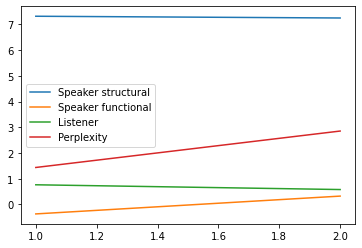

In [24]:
plt.plot(steps, speaker_losses_structural, label="Speaker structural")
plt.plot(steps, speaker_losses_functional, label="Speaker functional")
plt.plot(steps, listener_losses, label="Listener")
plt.plot(steps, perplexities, label="Perplexity")
plt.legend()
plt.show()

### Testing the pretrained sepaker

Below, some initial code for testing the pretrained speaker (basic image captioning model) is provided. Ignore for now.

In [54]:
# transforms like in train
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,
                         mode='val',
                         batch_size=1,
                         vocab_threshold=11,
                         vocab_from_file=True,
                         download_dir="../../../data/val", 
#                          vocab_file='../../../data/vocab.pkl'
                        )

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Obtaining caption lengths...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


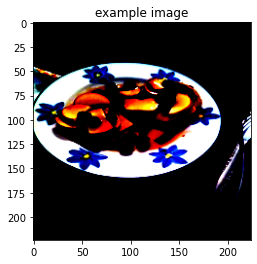

In [57]:
# Visualize sample image, before pre-processing.
orig_image, image = next(iter(data_loader_test))

plt.imshow(orig_image.squeeze(0).permute(1,2,0))
plt.title('example image')
plt.show()
# orig_image.squeeze(0).shape

In [50]:
orig_image.shape

torch.Size([1, 3, 224, 224])

In [52]:

def clean_sentence(output):
    """
    Transform list of indices to a sentence.
    """
    list_string = []
    
    for idx in output:
        list_string.append(data_loader_test.dataset.vocab.idx2word[idx.item()])
    
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence


encoder_file = 'encoder-earlystoppiing-4.pkl' 
decoder_file = 'decoder-earlystopping-4.pkl'

embed_size = 512
visual_embed_size = 1024
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)
print("VOCAB: ", vocab_size)
# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(visual_embed_size)
encoder.eval()
decoder = DecoderRNN(visual_embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./../models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./../models', decoder_file)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

VOCAB:  6039


DecoderRNN(
  (lstm): LSTM(1024, 512, batch_first=True)
  (embed): Embedding(6039, 1024)
  (linear): Linear(in_features=512, out_features=6039, bias=True)
)

In [58]:
image = image.to(device)
print("ImGAE", image.shape)
# Obtain the embedded image features.
features = encoder(orig_image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output, log_p, raw = decoder.sample(features, 27)
print('example output:', output)
sentence = clean_sentence(output)
print('example sentence:\n', sentence)

ImGAE torch.Size([1, 15])
example output: [tensor([0]), tensor([4]), tensor([805]), tensor([14]), tensor([110]), tensor([22]), tensor([4]), tensor([217]), tensor([14]), tensor([279]), tensor([19]), tensor([1]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3]), tensor([3])]
example sentence:
 A plate of food with a glass of water . end pad pad pad pad pad pad pad pad pad pad pad pad pad pad


Ideally, the pretrained speaker model should be evaluated in order to estimate the quality of the base performance, since it is critical for any kinds of changes that could follow from functional training. The evaluation should contain some standard methods like BLEU, and maybe one or two language drift explorations. Some examples should be inspected manually, too.  
In case the performance is bad, the following aspects could be tweaked: train longer (larger early stopping delta), different NN weight initialization, more data. 

### References

The code was created with the help of [this](https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319) and [this](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63) tutorial.